This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      804
Number of nonzeros in inequality constraint Jacobian.:      100
Number of nonzeros in Lagrangian Hessian.............:      600

Total number of variables............................:      302
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      204
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.81e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

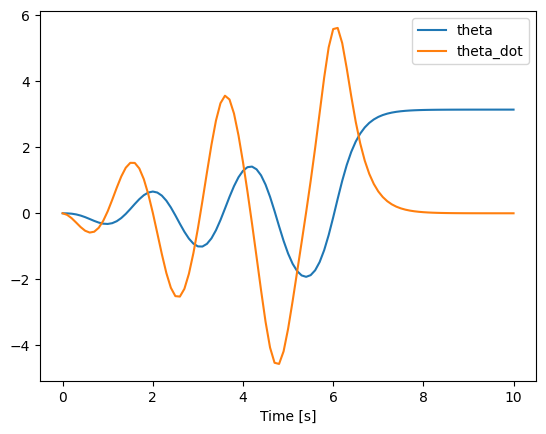

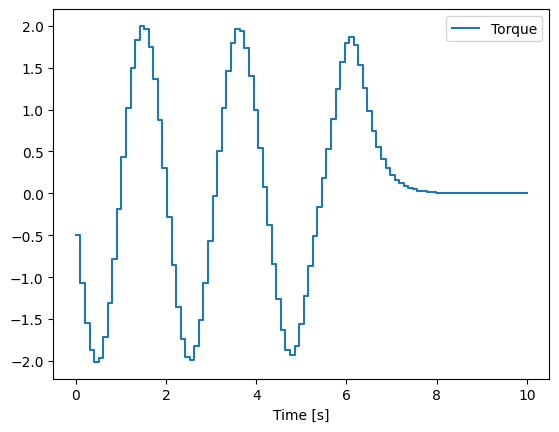

In [15]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100             # control intervals
g = 9.81            # gravity
l = 1.0             # length of pendulum
m = 1.0             # mass
fixed_T = 10.0       # fixed final time

# Optimization problem
opti = Opti()

# Decision variables
X = opti.variable(2, N+1)  # [theta, theta_dot] trajectory
U = opti.variable(1, N)    # control torque

# States
theta = X[0, :]
theta_dot = X[1, :]

# Dynamics (theta_dot, theta_ddot)
def f(x, u):
    th, th_dot = x[0], x[1]
    th_ddot = (-g/l * sin(th) + u / (m * l**2))
    return vertcat(th_dot, th_ddot)

# Objective: minimize control effort
opti.minimize(sumsqr(U))

# Time step
dt = fixed_T/N

# Dynamics constraints via RK4
for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    k1 = f(xk, uk)
    k2 = f(xk + dt/2 * k1, uk)
    k3 = f(xk + dt/2 * k2, uk)
    k4 = f(xk + dt * k3, uk)
    x_next = xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    opti.subject_to(X[:, k+1] == x_next)

# Bounds
u_max = 3.0
opti.subject_to(opti.bounded(-u_max, U, u_max))

# Initial and final conditions
opti.subject_to(theta[0] == 0)          # start pointing down
opti.subject_to(theta_dot[0] == 0)      # start at rest
opti.subject_to(theta[-1] == np.pi)     # swing up
opti.subject_to(theta_dot[-1] == 0)     # and stabilize

# Initial guesses
opti.set_initial(U, 0)
opti.set_initial(theta, np.linspace(0, np.pi, N+1))
opti.set_initial(theta_dot, 0)

# Solver
opti.solver("ipopt")
sol = opti.solve()

# Extract solution
t = np.linspace(0, fixed_T, N+1)
theta_sol = sol.value(theta)
theta_dot_sol = sol.value(theta_dot)
u_sol = sol.value(U)

# Plot
plt.figure()
plt.plot(t, theta_sol, label='theta')
plt.plot(t, theta_dot_sol, label='theta_dot')
plt.xlabel('Time [s]')
plt.legend()

plt.figure()
plt.step(np.linspace(0, fixed_T, N), u_sol, label='Torque', where='post')
plt.xlabel('Time [s]')
plt.legend()

plt.show()

In [20]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100             # control intervals
g = 9.81            # gravity
l = 1.0             # length of pendulum
m = 1.0             # mass
fixed_T = 10.0       # fixed final time

# Optimization problem
opti = Opti()

# Decision variables
X = opti.variable(3, N+1)  # [theta, theta_dot] trajectory
U = opti.variable(1, N)    # control torque

# States
cos_theta = X[0, :]
sin_theta = X[1, :]
theta_dot = X[2, :]

# Dynamics (theta_dot, theta_ddot)
def f(x, u):
    c_th, s_th, th_dot = x[0], x[1], x[2]
    
    c_th_dot = -s_th * th_dot
    s_th_dot = c_th * th_dot
    th_ddot = (-g/l * s_th + u / (m * l**2))
    
    return vertcat(c_th_dot, s_th_dot, th_ddot)

# Objective: minimize control effort
opti.minimize(sumsqr(U))

# Time step
dt = fixed_T/N

# Dynamics constraints via RK4
for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    k1 = f(xk, uk)
    k2 = f(xk + dt/2 * k1, uk)
    k3 = f(xk + dt/2 * k2, uk)
    k4 = f(xk + dt * k3, uk)
    x_next = xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    opti.subject_to(X[:, k+1] == x_next)

# Bounds
u_max = 10.0
opti.subject_to(opti.bounded(-u_max, U, u_max))

# Initial and final conditions
opti.subject_to(cos_theta[0] == np.cos(0))          # start pointing down
opti.subject_to(sin_theta[0] == np.sin(0))          # start pointing down
opti.subject_to(theta_dot[0] == 0)      # start at rest
opti.subject_to(cos_theta[-1] == np.cos(np.pi))     # swing up
opti.subject_to(sin_theta[-1] == np.sin(np.pi))     # swing up
opti.subject_to(theta_dot[-1] == 0)     # and stabilize

# Initial guesses
opti.set_initial(U, 0)
opti.set_initial(cos_theta, np.linspace(np.cos(0), np.cos(np.pi), N+1))
opti.set_initial(sin_theta, np.linspace(np.sin(0), np.sin(np.pi), N+1))
opti.set_initial(theta_dot, 0)

# Solver
opti.solver("ipopt")
sol = opti.solve()

# Extract solution
t = np.linspace(0, fixed_T, N+1)
cos_theta_sol = sol.value(cos_theta)
sin_theta_sol = sol.value(sin_theta)
theta_dot_sol = sol.value(theta_dot)
u_sol = sol.value(U)
theta_sol = np.arctan2(sin_theta_sol, cos_theta_sol)

# Plot
plt.figure()
plt.plot(t, theta_sol, label='theta')
plt.plot(t, theta_dot_sol, label='theta_dot')
plt.xlabel('Time [s]')
plt.legend()

plt.figure()
plt.step(np.linspace(0, fixed_T, N), u_sol, label='Torque', where='post')
plt.xlabel('Time [s]')
plt.legend()

plt.show()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1506
Number of nonzeros in inequality constraint Jacobian.:      100
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:      403
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      306
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e-02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

CasADi - 2025-04-17 23:26:43 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'